In [1]:
import sys
sys.path.append("..")
import Data as dt
import ChevalParesseux_lib as lib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

This notebook aims to perform an extensive usage of the Features classes in order to verify that they work as expected. 

# **I. Import Data**

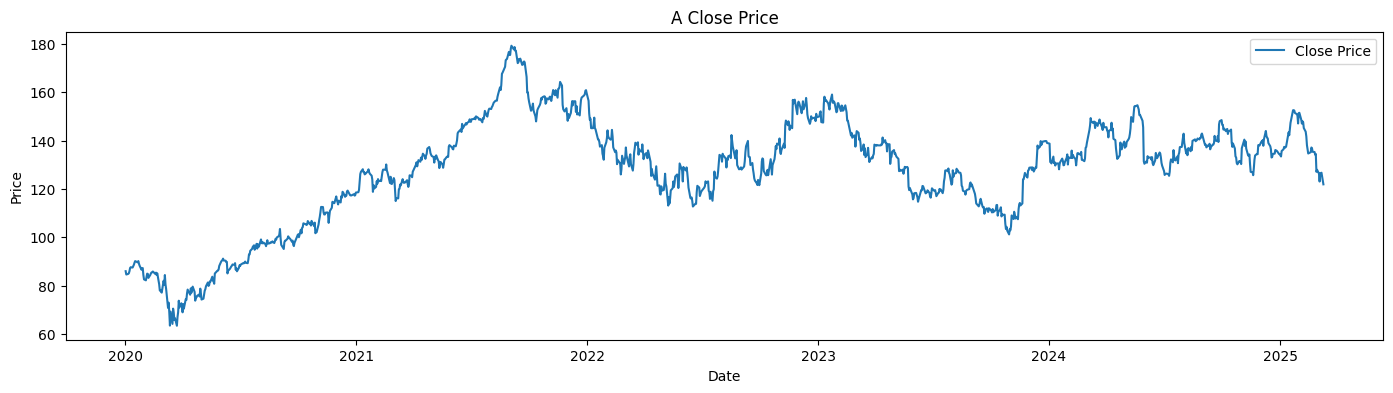

In [2]:
# ======= I. Load Data =======
data = dt.load_data(ticker='A')
data = data[data['date'] > '2020-01-01']
data.index = pd.to_datetime(data['date'])

alt_data = dt.load_data(ticker='AAPL')
alt_data = alt_data[alt_data['date'] > '2020-01-01']
alt_data.index = pd.to_datetime(alt_data['date'])

# ======= II. Plot Data to ensure its integrity =======
plt.figure(figsize=(17, 4))
plt.plot(data['close'], label='Close Price')
plt.title('A Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# **II. Prepare feature class**

In [3]:
# ======= I. User Defining Parameters =======
feature_model = lib.kalmanOU_feature
feature_params = {
    'window': [100],
    'smoothing_method': [None],
    'window_smooth': [5],
    'lambda_smooth': [0.2],
}

feature_name = 'cointegration'
n_jobs = 10

In [4]:
# ======= II. Initialize =======
feature = feature_model(name=feature_name, n_jobs=n_jobs)

# ======= III. Set the Parameters =======
feature = feature.set_params(**feature_params)

# **III. Checking Smoothing/Preprocessing Method**

In [5]:
# smoothed_data_ewma = feature.smooth_data(data=data['close'], smoothing_method='ewma', window_smooth=10, lambda_smooth=0.2)
# smoothed_data_ma = feature.smooth_data(data=data['close'], smoothing_method='average', window_smooth=10, lambda_smooth=0.2)

# processed_data = feature.process_data(data=smoothed_data_ewma)

# plt.figure(figsize=(17, 4))
# plt.plot(data['close'], label='Close Price')
# plt.plot(smoothed_data_ewma, label='Smoothed Close Price using EWMA', color='orange')
# plt.plot(smoothed_data_ma, label='Smoothed Close Price using MA', color='green')
# plt.plot(processed_data, label='Processed Data', color='red')
# plt.title('A Close Price')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.show()

# **IV. Checking Extraction**

In [6]:
tuple_data = (np.log(data['close']), np.log(alt_data['close']))

[{'window': 100, 'residuals_weights': None, 'smooth_coefficient': 0.2, 'smoothing_method': None, 'window_smooth': 5, 'lambda_smooth': 0.2}, {'window': 100, 'residuals_weights': None, 'smooth_coefficient': 0.5, 'smoothing_method': None, 'window_smooth': 5, 'lambda_smooth': 0.2}, {'window': 100, 'residuals_weights': None, 'smooth_coefficient': 0.8, 'smoothing_method': None, 'window_smooth': 5, 'lambda_smooth': 0.2}, {'window': 100, 'residuals_weights': [1, 0], 'smooth_coefficient': 0.2, 'smoothing_method': None, 'window_smooth': 5, 'lambda_smooth': 0.2}, {'window': 100, 'residuals_weights': [1, 0], 'smooth_coefficient': 0.5, 'smoothing_method': None, 'window_smooth': 5, 'lambda_smooth': 0.2}, {'window': 100, 'residuals_weights': [1, 0], 'smooth_coefficient': 0.8, 'smoothing_method': None, 'window_smooth': 5, 'lambda_smooth': 0.2}]


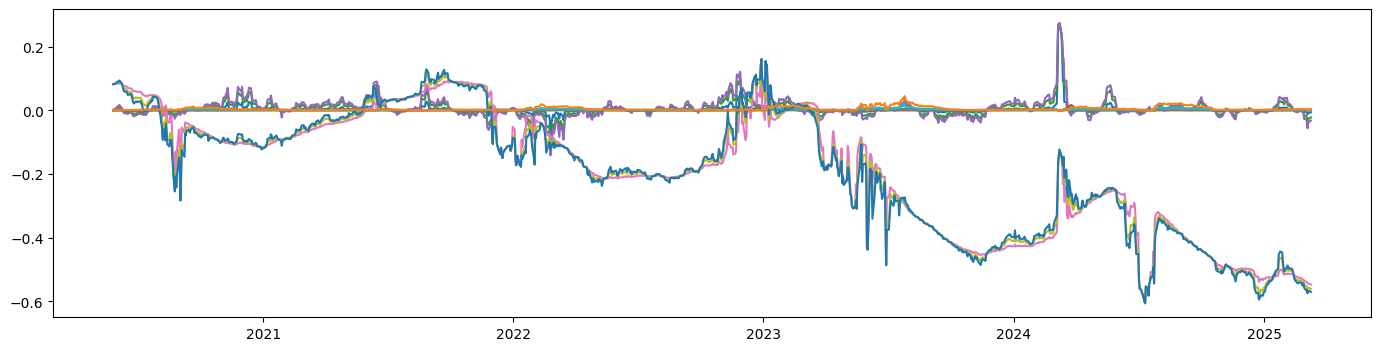

In [7]:
features_df = feature.extract(data=tuple_data)
# alt_features_df = feature.extract(data=alt_data['close'])

plt.figure(figsize=(17, 4))
plt.plot(features_df)
plt.show()

# plt.figure(figsize=(17, 4))
# plt.plot(alt_features_df)
# plt.show()